My notebook for the [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer/) Competition

The notebook is inspired by both [fastai](fast.ai) and [this Kaggle notebook](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import Torch Libraries

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [3]:
# Import Other Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
PATH = 'data/'
!ls {PATH}

imgs                  sample_submission.csv train.csv
labels.csv            test.csv


In [72]:
train_df = pd.read_csv("./data/train.csv", dtype = np.float32)

print(train_df.shape)
train_df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
test_df = pd.read_csv("./data/test.csv", dtype = np.float32)

print(test_df.shape)
test_df.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare Data

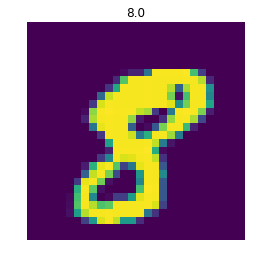

In [70]:
# Prepare Dataset
# load data
train = pd.read_csv("./data/train.csv", dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [ ]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [71]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 
 1.8264
[torch.FloatTensor of size 1]
  Accuracy: 65.73809523809524%
Iteration: 1000  Loss: 
 1.6050
[torch.FloatTensor of size 1]
  Accuracy: 75.11904761904762%
Iteration: 1500  Loss: 
 1.2763
[torch.FloatTensor of size 1]
  Accuracy: 78.25%
Iteration: 2000  Loss: 
 1.2001
[torch.FloatTensor of size 1]
  Accuracy: 79.76190476190476%
Iteration: 2500  Loss: 
 1.0312
[torch.FloatTensor of size 1]
  Accuracy: 80.73809523809524%
Iteration: 3000  Loss: 
 0.9305
[torch.FloatTensor of size 1]
  Accuracy: 81.44047619047619%
Iteration: 3500  Loss: 
 0.8987
[torch.FloatTensor of size 1]
  Accuracy: 82.13095238095238%
Iteration: 4000  Loss: 
 0.7539
[torch.FloatTensor of size 1]
  Accuracy: 82.76190476190476%
Iteration: 4500  Loss: 
 0.9729
[torch.FloatTensor of size 1]
  Accuracy: 83.25%
Iteration: 5000  Loss: 
 0.8082
[torch.FloatTensor of size 1]
  Accuracy: 83.66666666666667%
Iteration: 5500  Loss: 
 0.7554
[torch.FloatTensor of size 1]
  Accuracy: 84.03571428571429%
It

In [45]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [49]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

Normalize data into 3 channel lists

In [69]:
train_imgs = train_df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
print(train_imgs.shape)

(42000, 28, 28, 1)


In [8]:
test_imgs = test_df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
print(test_imgs.shape)

(28000, 28, 28, 1)


In [9]:
numbers = torch.from_numpy(train_df.iloc[:,0].values)
len(numbers)

42000

In [10]:
X_train_3 = np.broadcast_to(train_imgs, (42000, 28, 28, 3))

In [11]:
X_test_3 = np.broadcast_to(test_imgs, (28000, 28, 28, 3))

In [12]:
from PIL import Image

counter = 1
for image in X_train_3:
        image = Image.fromarray(image, 'RGB')
        image.save(f"./data/imgs/train/{counter}.jpg")
        counter += 1

In [13]:
from PIL import Image

counter = 1
for image in X_test_3:
        image = Image.fromarray(image, 'RGB')
        image.save(f"./data/imgs/test/{counter}.jpg")
        counter += 1

In [17]:
import csv

with open('./data/labels.csv', 'w') as csvfile:
    counter = 0
    for number in numbers:
        counter += 1
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow([counter, number])

In [18]:
label_csv = './data/labels.csv'
n = len(list(open(label_csv)))
val_idxs = get_cv_idxs(n)

In [19]:
len(val_idxs)

8400

In [28]:
label_df = pd.read_csv(label_csv)
label_df.head()

,1,1.1
0,2,0
1,3,1
2,4,4
3,5,0
4,6,0


In [33]:
img = PIL.Image.open('data/imgs/train/2.jpg'); img

In [34]:
img.size

(28, 28)

In [20]:
arch=resnet50
sz=28
bs=32

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)

data = ImageClassifierData.from_csv('./data/imgs/', 'train', label_csv, test_name='test', 
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [22]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.34679    0.21914    0.927381  



[array([ 0.21914]), 0.92738095238095242]

In [23]:
learn

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=512)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=10)
  (7): LogSoftmax()
)

 11%|█         | 118/1050 [00:06<00:48, 19.07it/s, loss=0.314]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/iacutone/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/iacutone/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/iacutone/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 73%|███████▎  | 768/1050 [00:40<00:14, 19.11it/s, loss=1.14] 


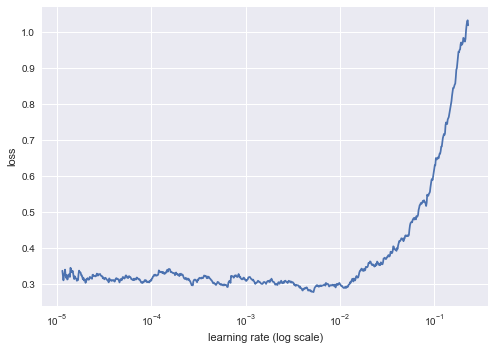

 73%|███████▎  | 768/1050 [00:56<00:20, 13.70it/s, loss=1.14]

In [26]:
lrf=learn.lr_find()
learn.sched.plot()

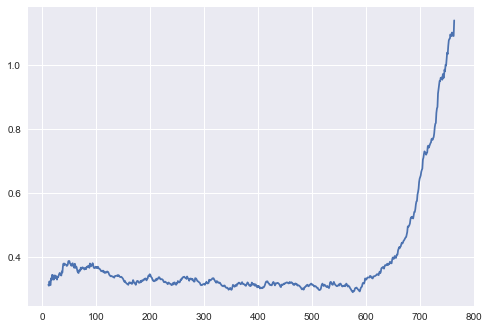

 73%|███████▎  | 766/1050 [00:50<00:18, 15.32it/s, loss=1.17]

In [25]:
learn.sched.plot_loss()

In [27]:
data.classes


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [35]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.301917   0.175673   0.945119  
    1      0.270362   0.168178   0.942857                      
    2      0.261366   0.159048   0.947381                      
    3      0.264913   0.157417   0.950714                      
    4      0.245642   0.146028   0.953214                      
    5      0.222402   0.137338   0.955                         
    6      0.218452   0.138462   0.953929                      



[array([ 0.13846]), 0.95392857142857146]

In [36]:
data.test_ds.fnames

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg',
 'test/10001.jpg',
 'test/10002.jpg',
 'test/10003.jpg',
 'test/10004.jpg',
 'test/10005.jpg',
 'test/10006.jpg',
 'test/10007.jpg',
 'test/10008.jpg',
 'test/10009.jpg',
 'test/1001.jpg',
 'test/10010.jpg',
 'test/10011.jpg',
 'test/10012.jpg',
 'test/10013.jpg',
 'test/10014.jpg',
 'test/10015.jpg',
 'test/10016.jpg',
 'test/10017.jpg',
 'test/10018.jpg',
 'test/10019.jpg',
 'test/1002.jpg',
 'test/10020.jpg',
 'test/10021.jpg',
 'test/10022.jpg',
 'test/10023.jpg',
 'test/10024.jpg',
 'test/10025.jpg',
 'test/10026.jpg',
 'test/10027.jpg',
 'test/10028.jpg',
 'test/10029.jpg',
 'test/1003.jpg',
 'test/10030.jpg',
 'test/10031.jpg',
 'test/10032.jpg',
 'test/10033.jpg',
 'test/10034.jpg',
 'test/10035.jpg',
 'test/10036.jpg',
 'test/10037.jpg',
 'test/10038.jpg',
 'test/10039.jpg',
 'test/1004.jpg',
 'test/10040.jpg',
 'test/10041.jpg',
 'test/10042.jpg',
 'test/10043.jpg',
 'test/10044.jpg',
 'test/

In [37]:
log_preds, y = learn.TTA(is_test=True)
probs = np.exp(log_preds)